In [2]:
from utils import load_nii, load_nii_multi

import os, cv2
import numpy as np
from matplotlib import pyplot as plt

# Data_Loader 순서

1. Patient list 
2. Read nifti image
3. Make Low data
4. Make High data


In [17]:
def data_loader_v3(PATH, val_idx = 0, img = 'rsl', norm=True):
    train_low = []
    train_high = None
    val_low = []
    test_low = []
    sequence = {'train':[], 'test':[]}
    # Loading Patient list & Seperating Train lists & Validation lists
    Pat_lists = sorted(os.listdir(PATH))
    val_pat = Pat_lists[val_idx]
    Pat_lists.pop(val_idx)
    
    
    ## Train lists loop
    for i, pat in enumerate(Pat_lists):
        # Load t1, dante
        Pat_path = os.path.join(PATH, pat)
        #print(Pat_path)
        tmp_t1, tmp_dante = load_nii_multi(Pat_path,  img = img) # (H, W, S)
        if norm:
            tmp_t1 = tmp_t1/tmp_t1.max()
            tmp_dante = tmp_dante/tmp_dante.max()
        
        # Spliting dante data (H, W, S) -> (S/6, H, W, 6)
        _, _, s = tmp_dante.shape
        tmp_dante = np.array(np.dsplit(tmp_dante, s/6))[1:] # 첫번째 data는 불량으로 제외.
        batch, h, w, _ = tmp_dante.shape
        
        # Make Train Low
        mean_dante = tmp_dante.mean(axis=-1)  # (S/6, H, W)
        for j in range(batch):
            empty = np.zeros((3, h, w))
            if j==0:
                empty[1:,...] = mean_dante[:2]
            elif j==batch-1:
                empty[:2,...] = mean_dante[-2:]
            else:
                empty = mean_dante[j-1:j+2]
            
            empty = np.transpose(empty, [1, 2, 0])
            train_low.append(empty)
        
        # Make Train High
        tmp_high = np.zeros((batch, h, w, 12))
        tmp_high[..., 3:-3] = tmp_dante
        tmp_high[1:, ..., :3] = tmp_dante[:-1, ..., 3:]
        tmp_high[:-1, ..., -3:] = tmp_dante[1:, ..., :3]
        
        if i==0:
            train_high = tmp_high
        else:
            train_high = np.concatenate([train_high, tmp_high], axis=0)
            
        # Make Test Low
        tmp_t1 = np.transpose(tmp_t1, (2, 0, 1)) # (S, H, W)
        batch, h, w = tmp_t1.shape
        for j in range(batch):
            empty = np.zeros((3, h, w))
            if j==0:
                empty[1:,...] = tmp_t1[:2]
            elif j==batch-1:
                empty[:2,...] = tmp_t1[-2:]
            else:
                empty = tmp_t1[j-1:j+2]
            
            empty = np.transpose(empty, [1, 2, 0])
            test_low.append(empty)
        #sequence['test'].append(batch)
    
    
    ## Validation
    
    # Load image
    Pat_path = os.path.join(PATH, val_pat)
    test_t1, tmp_val_high = load_nii_multi(Pat_path,  img = img)
    if norm:
        test_t1 = test_t1/test_t1.max()
        tmp_val_high = tmp_val_high/tmp_val_high.max()
    # Spliting dante data (H, W, S) -> (S/6, H, W, 6)
    h, w, s = tmp_val_high.shape
    tmp_val_high = np.array(np.dsplit(tmp_val_high, s/6))[1:]
    batch, h, w, _ = tmp_val_high.shape
    
    # Make Validation Low
    mean_dante = tmp_val_high.mean(axis=-1)  # (S/6, H, W)
    
    for j in range(batch):
        empty = np.zeros((3, h, w))
        if j==0:
            empty[1:,...] = mean_dante[:2]
        elif j==batch-1:
            empty[:2,...] = mean_dante[-2:]
        else:
            empty = mean_dante[j-1:j+2]

        empty = np.transpose(empty, [1, 2, 0])
        val_low.append(empty)

    # Make Train High
    val_high = np.zeros((batch, h, w, 12))
    val_high[..., 3:-3] = tmp_val_high
    val_high[1:, ..., :3] = tmp_val_high[:-1, ..., 3:]
    val_high[:-1, ..., -3:] = tmp_val_high[1:, ..., :3]
    
    
    
    
    test_t1 = np.transpose(test_t1, (2, 0, 1)) # (S, H, W)
    s, h, w = test_t1.shape
    for j in range(s//6):
        empty = np.zeros((3, h, w))
        if j==0:
            empty[1:,...] = test_t1[:2]
        elif j==s/6-1:
            empty[:2,...] = test_t1[-2:]
        else:
            empty = test_t1[j-1:j+2]

        empty = np.transpose(empty, [1, 2, 0])
        test_low.append(empty)
        
    #val_dante = np.transpose(val_dante, [2, 0, 1])
    #val_dante = np.reshape(val_dante, [len(val_dante)//6, 6, 320, 256])
    #val_dante = np.transpose(val_dante, [0, 2, 3, 1])
    #val_t1 = np.expand_dims(np.transpose(val_t1, [2, 0, 1]), -1)
    
    return np.array(train_low), train_high, np.array(val_low), val_high, np.array(test_low)


In [19]:
Data_root = './interpolation/'
train_low, train_high, val_low, val_high, test_low = data_loader_v3(Data_root, img='rsl')

print(train_low.shape)
print(train_high.shape)
print(val_low.shape)
print(val_high.shape)
print(test_low.shape)

(303, 320, 256, 3)
(303, 320, 256, 12)
(25, 320, 256, 3)
(25, 320, 256, 12)
(320, 320, 256, 3)


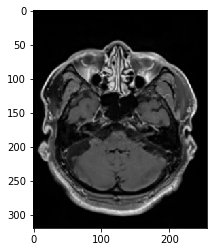

In [23]:
plt.imshow(train_high[4,...,0], cmap='gray')

In [27]:
from ipywidgets import interact

def plot_fn_single(img):
    mdx = len(img)-1
    def plot(idx=0):
        plt.figure(figsize=(20, 10))
        for i in range(12):
            plt.subplot(2, 6, i+1)
            plt.imshow(img[idx, ..., i], cmap='gray', vmin=0, vmax=img[idx].max())
            plt.xlabel("%f ~ %f"%(0, img[idx, ..., i].max()))
    interact(plot, idx=(0, mdx, 1))